In [1]:
# In this notebook, you learn:
#
# 1) How to implement a single Perceptron using our backpropagation framework?
# 2) How to create a layer of Perceptrons?
# 3) How to create a multi-layer Perceptron?

In [2]:
import math
import random

from graphviz import Digraph
from queue import Queue
from typing import Any, Callable, List, Set, Tuple, Union

In [3]:
def topological_sort(root: Any) -> List[Any]:
    visited: Set[Any] = set()
    topo_order: List[Any] = []
    def dfs(node: Any):
        if node in visited:
            return
        visited.add(node)
        if node.children:
            for child in node.children:
                dfs(child)
        topo_order.append(node)
    dfs(root)
    topo_order.reverse()
    return topo_order

In [4]:
class Value:
    def __init__(self, data: float, label: str="", operation: str=None, children: Tuple=None):
        self.data = data
        self.label = label
        self.operation = operation
        self.children = children
        self.grad = 0.0
        self.grad_propagator = None
    
    def __add__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data + other.data, operation="+", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result
    
    def __radd__(self, other: Union[float, int]) -> 'Value':
        other: Value = Value(other)
        result = Value(self.data + other.data, operation="+", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result
    
    def __mul__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data * other.data, operation="*", children=(self, other)) 
        def grad_propagator():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result
    
    def __rmul__(self, other: Union[float, int]) -> 'Value':
        other = Value(other)
        result = Value(self.data * other.data, operation="*", children=(self, other)) 
        def grad_propagator():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result

    def __sub__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data - other.data, operation=f"{self.data}-{other.data}", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad -= result.grad
        result.grad_propagator = grad_propagator
        return result

    def __rsub__(self, other: Union[float, int]) -> 'Value':
        other = Value(other)
        result = Value(other.data - self.data, operation=f"{other.data}-{self.data}", children=(other, self))
        def grad_propagator():
            self.grad -= result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result

    def __truediv__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data / other.data, operation=f"{self.data}/{other.data}", children=(self, other))
        def grad_propagator():
            self.grad += result.grad / other.data
            other.grad -= ((result.grad * self.data) / other.data**2)
        result.grad_propagator = grad_propagator
        return result

    def __pow__(self, other: Union['Value', float]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data ** other.data, operation=f"{self.data}^{other.data}", children=(self, other))
        def grad_propagator():
            self.grad += result.grad * other.data * self.data**(other.data - 1)
            other.grad += result.grad * result.data * math.log(self.data)
        result.grad_propagator = grad_propagator
        return result

    def __rpow__(self, other: Union[int, float]) -> 'Value':
        other = Value(other)
        result = Value(other.data ** self.data, operation=f"{other.data}^{self.data}", children=(other, self))
        def grad_propagator():
            self.grad += result.grad * result.data * math.log(other.data)
            other.grad += result.grad * self.data * other.data**(self.data - 1)
        result.grad_propagator = grad_propagator
        return result

    # Lets implement the tanh function using other operations like addition, multiplication, exponentiation, and division.
    # This is to show that we can either implement complex operations (and their gradients) as a single automic operation 
    # or as a combination of simpler operations.
    def tanh(self) -> 'Value':
        computed_data = (math.exp(self.data) - math.exp(-self.data))/(math.exp(self.data) + math.exp(-self.data))
        result = Value(data=computed_data, operation="tanh", children=(self,))
        def grad_propagator():
            # The derivative of tanh is (1 - tanh^2). This is used to calculate the gradients of the children nodes.
            self.grad += (1.0 - computed_data**2) * result.grad
        result.grad_propagator = grad_propagator
        return result

    def backward(self):
        topo_order: List[Value] = topological_sort(self)
        self.grad = 1.0
        for node in topo_order:
            if node.grad_propagator is None:
                continue
            node.grad_propagator()

    def __repr__(self) -> str:
        return f"label: {self.label} | data: {self.data} | operation: {self.operation} | grad: {self.grad}"

In [5]:
def get_nodes_and_edges(root: Value) -> Tuple[Set[Value], Set[Tuple[Value, Value]]]:
    """Returns all the nodes and edges in the expression tree. Does not nodes for the operations.

    Args:
        root (Value): The root node (the final output object) of the expression tree.

    Returns:
        Tuple[Set[Value], Set[Tuple[Value, Value]]]: A tuple containing the set of nodes and set 
                                                     of edges in the expression tree.
    """
    nodes = set()
    edges = set()
    visited = set()
    queue = Queue()
    queue.put(root)
    while not queue.empty():
        node = queue.get()
        if node in visited:
            continue
        visited.add(node)
        nodes.add(node)
        if node.children:
            for child in node.children:
                edges.add((child, node))
                queue.put(child)
    return nodes, edges

def get_expression_graph(root: Value) -> Digraph:
    """Returns a graph that visualizes the expression created using the Value_4 objects.

    Args:
        root (Value): The root node (the final output object) of the expression tree.

    Returns:
        Digraph: DOT language graph that visualizes the expression created using the Value objects.
    """
    dot = Digraph(name="ExpressionGraph", 
                  comment="Constructs the expression graph using the Value objects.",
                  format="png",
                  graph_attr={"rankdir": "LR"})
    nodes, edges = get_nodes_and_edges(root)
    for node in nodes:
        unique_id: str = str(id(node))
        dot.node(name=unique_id, label=f"{node.label} | data {node.data:.4f} | grad {node.grad:.4f}", shape="record")
        if node.operation:
            dot.node(name=f"{unique_id}_{node.operation}", label=node.operation)
            dot.edge(tail_name=f"{unique_id}_{node.operation}", head_name=unique_id)
    for edge in edges:
        from_node, to_node = edge
        dot.edge(tail_name=str(id(from_node)), head_name=f"{str(id(to_node))}_{to_node.operation}")
    return dot

## Perceptron

In [6]:
# Perceptron is a single neuron that takes multiple inputs, applies weights to them, sums them up, and 
# applies an activation function. The output of the activation function is the output of the perceptron.
# The weights are learned using backpropagation. We will implement a single perceptron using our 
# backpropagation framework.
# The mathematical representation of a perceptron is:
#
# output = activation_function(sum(weight_i * input_i) + bias)
#
# where activation_function is a non-linear function like sigmoid, tanh, or relu.

$f_{ac}$ - activation function <br>
$x_{i}$ - $ith$ input <br>
$w_{i}$ - $ith$ weight 

Then the function computed by the perceptron is:

$$output = f_{ac}(\sum_{i=1}^{num\_inputs}(w_{i} * x_{i}) + b)$$

In [7]:
# Perceptron needs to know the number of inputs it will receive. This is because it needs to initialize
# the weights and biases for each input. The weights are initialized randomly and the bias is initialized
# to 0.
class Perceptron:
    def __init__(self, num_inputs: int):
        self.weights = [Value(data=random.uniform(a=0, b=1), label=f"w{i}") for i in range(num_inputs)]
        self.bias = Value(data=0.0, label="b")

    def __call__(self, inputs: List[Value]) -> Value:
        weighted_sum = self.bias
        for input_value, weight in zip(inputs, self.weights):
            weighted_sum += input_value * weight
        output = weighted_sum.tanh()
        return output

    def log_parameters(self):
        print("Weights:")
        for weight in self.weights:
            print(weight)
        print("-" * 50)           
        print("Bias:")
        print(self.bias)

In [8]:
perceptron = Perceptron(num_inputs=3)
perceptron.log_parameters()

Weights:
label: w0 | data: 0.5317839695210894 | operation: None | grad: 0.0
label: w1 | data: 0.9586796692679801 | operation: None | grad: 0.0
label: w2 | data: 0.7459727953641637 | operation: None | grad: 0.0
--------------------------------------------------
Bias:
label: b | data: 0.0 | operation: None | grad: 0.0


In [9]:
inputs1 = [Value(data=1.0, label="x0"), Value(data=2.0, label="x1"), Value(data=3.0, label="x2")]
for input in inputs1:
    print(input)

label: x0 | data: 1.0 | operation: None | grad: 0.0
label: x1 | data: 2.0 | operation: None | grad: 0.0
label: x2 | data: 3.0 | operation: None | grad: 0.0


In [10]:
# This calls the __call__ function.
output1 = perceptron(inputs1)
print(output1)

label:  | data: 0.9998302291712852 | operation: tanh | grad: 0.0


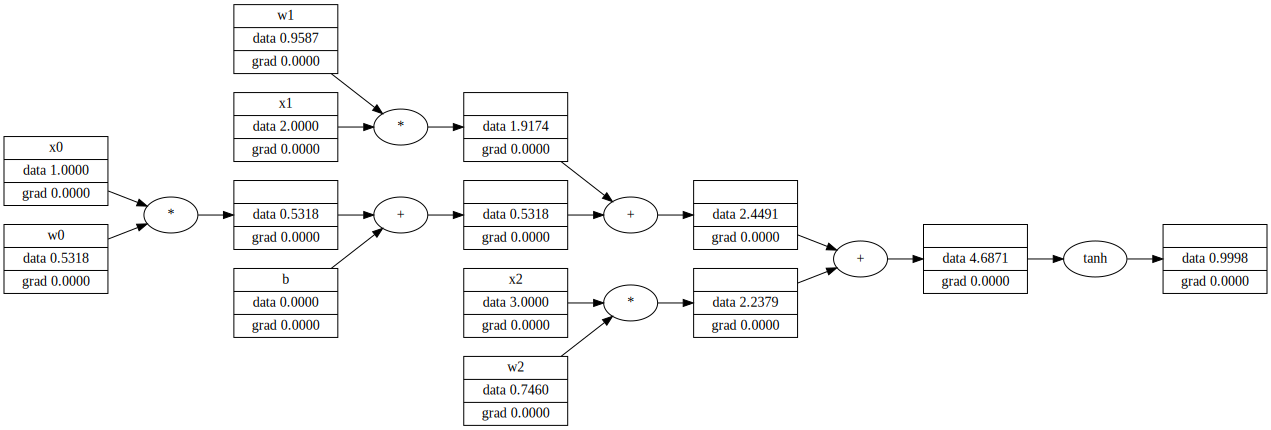

In [11]:
# Lets visualize the expression graph for the output1 without the gradients.
get_expression_graph(output1)

In [12]:
# Now, lets calculate the gradients for the output1.
output1.backward()

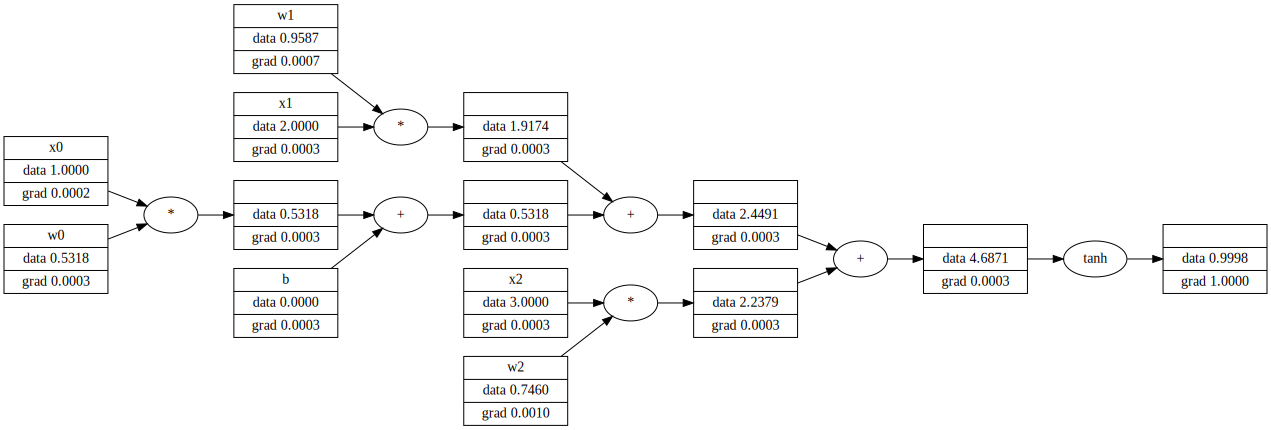

In [13]:
# Now, lets visualize the expression graph for the output1 with the gradients.
get_expression_graph(output1)

## Layer

In [14]:
# A layer is a collection of perceptrons. Each perceptron in the layer takes the same inputs but has 
# different weights and biases.
class Layer:
    def __init__(self, num_inputs: int, num_neurons: int):
        self.neurons = [Perceptron(num_inputs=num_inputs) for _ in range(num_neurons)]
    
    def __call__(self, inputs: List[Value]) -> List[Value]:
        outputs = []
        for idx, neuron in enumerate(self.neurons):
            outputs.append(neuron(inputs))
        return outputs        

    def log_parameters(self):
        for idx, neuron in enumerate(self.neurons):
            print(f"Neuron {idx}")
            neuron.log_parameters()
            print("-" * 100)

In [15]:
layer = Layer(num_inputs=3, num_neurons=2)
layer.log_parameters()

Neuron 0
Weights:
label: w0 | data: 0.24857521041306374 | operation: None | grad: 0.0
label: w1 | data: 0.5794612671461576 | operation: None | grad: 0.0
label: w2 | data: 0.34972455849004347 | operation: None | grad: 0.0
--------------------------------------------------
Bias:
label: b | data: 0.0 | operation: None | grad: 0.0
----------------------------------------------------------------------------------------------------
Neuron 1
Weights:
label: w0 | data: 0.6685970211225616 | operation: None | grad: 0.0
label: w1 | data: 0.4360633330455128 | operation: None | grad: 0.0
label: w2 | data: 0.8762479479320185 | operation: None | grad: 0.0
--------------------------------------------------
Bias:
label: b | data: 0.0 | operation: None | grad: 0.0
----------------------------------------------------------------------------------------------------


In [16]:
inputs2 = [Value(data=1.0, label="x0"), Value(data=2.0, label="x1"), Value(data=3.0, label="x2")]
for input in inputs2:
    print(input)

label: x0 | data: 1.0 | operation: None | grad: 0.0
label: x1 | data: 2.0 | operation: None | grad: 0.0
label: x2 | data: 3.0 | operation: None | grad: 0.0


In [17]:
outputs2 = layer(inputs2)
for output in outputs2:
    print(output)

label:  | data: 0.9854114263009616 | operation: tanh | grad: 0.0
label:  | data: 0.9995220607280401 | operation: tanh | grad: 0.0


In [18]:
# Here, we have two neurons which produce two outputs. Both these outputs are produced by the same inputs
# but with different weights and biases. 
# We need to visualize the expressions graph for each output separately even though they share the same 
# inputs.
# Notice that in the below graphs, the inputs have same data but the weights and biases are different.
# Do not get confused by the labels of the weights and biases in the two graphs. They are different 
# objects even though they have the same labels.

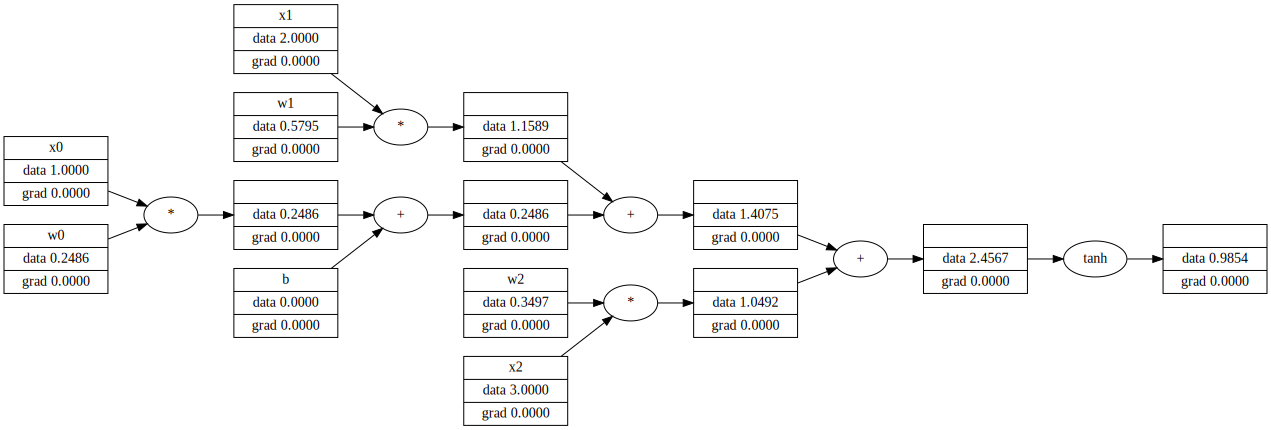

In [19]:
get_expression_graph(outputs2[0])

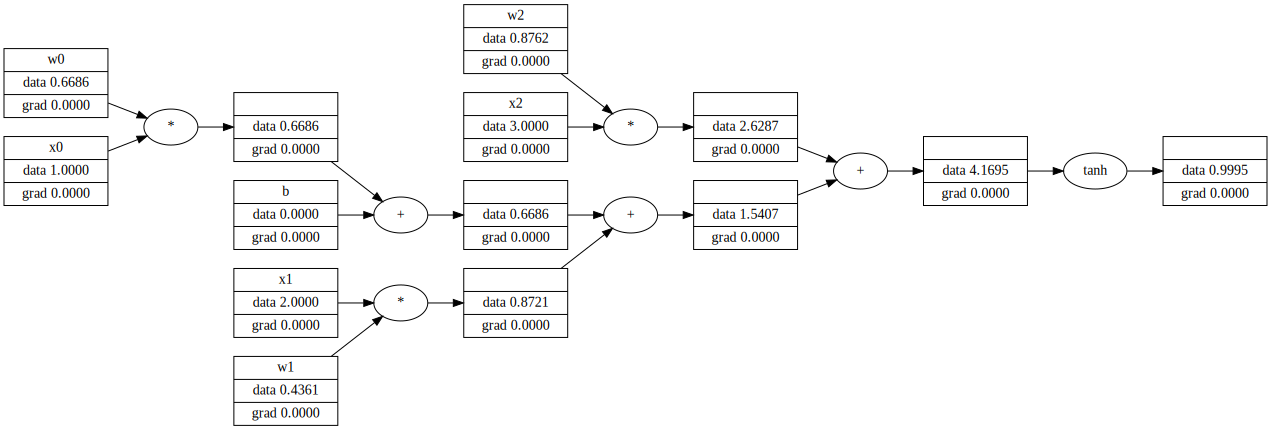

In [20]:
get_expression_graph(outputs2[1])

## Neural Network

In [21]:
# A Neural Network is a collection of layers. Each layer takes the outputs of the previous layer as inputs.
# The first layer takes the inputs to the neural network as inputs. The final output of the neural network
# is the output of the final layer. 

In [22]:
class MLP:
    def __init__(self, num_inputs: int, num_layers: int, num_neurons_per_layer: List[int]):
        self.layers = [Layer(num_inputs=num_inputs, num_neurons=num_neurons_per_layer[0])]
        for i in range(1, num_layers):
            self.layers.append(Layer(num_inputs=num_neurons_per_layer[i-1], num_neurons=num_neurons_per_layer[i]))
        
    def __call__(self, inputs: List[Value]) -> Value:
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs)
        # The assumption is that the final layer has only one neuron.
        return outputs[0]

    def log_parameters(self):
        for idx, layer in enumerate(self.layers):
            print(f"Layer {idx}")
            layer.log_parameters()
            print("-" * 150)

In [23]:
# Lets create a neural network with 3 layers. The first layer has 3 neurons, the second layer has 2 neurons,
# and the final layer has 1 neuron.
neural_network = MLP(num_inputs=3, num_layers=3, num_neurons_per_layer=[3, 2, 1])
neural_network.log_parameters()

Layer 0
Neuron 0
Weights:
label: w0 | data: 0.03211454599332275 | operation: None | grad: 0.0
label: w1 | data: 0.5278685270113096 | operation: None | grad: 0.0
label: w2 | data: 0.8465568675145573 | operation: None | grad: 0.0
--------------------------------------------------
Bias:
label: b | data: 0.0 | operation: None | grad: 0.0
----------------------------------------------------------------------------------------------------
Neuron 1
Weights:
label: w0 | data: 0.6816898820242759 | operation: None | grad: 0.0
label: w1 | data: 0.4931667472239215 | operation: None | grad: 0.0
label: w2 | data: 0.12991162165708303 | operation: None | grad: 0.0
--------------------------------------------------
Bias:
label: b | data: 0.0 | operation: None | grad: 0.0
----------------------------------------------------------------------------------------------------
Neuron 2
Weights:
label: w0 | data: 0.6978377493609279 | operation: None | grad: 0.0
label: w1 | data: 0.7128687217128418 | operation:

In [24]:
inputs3 = [Value(data=1.0, label="x0"), Value(data=2.0, label="x1"), Value(data=3.0, label="x2")]
for input in inputs3:
    print(input)

label: x0 | data: 1.0 | operation: None | grad: 0.0
label: x1 | data: 2.0 | operation: None | grad: 0.0
label: x2 | data: 3.0 | operation: None | grad: 0.0


In [25]:
output3 = neural_network(inputs3)
output3.label = "Output3"
print(output3)

label: Output3 | data: 0.6953854938442442 | operation: tanh | grad: 0.0


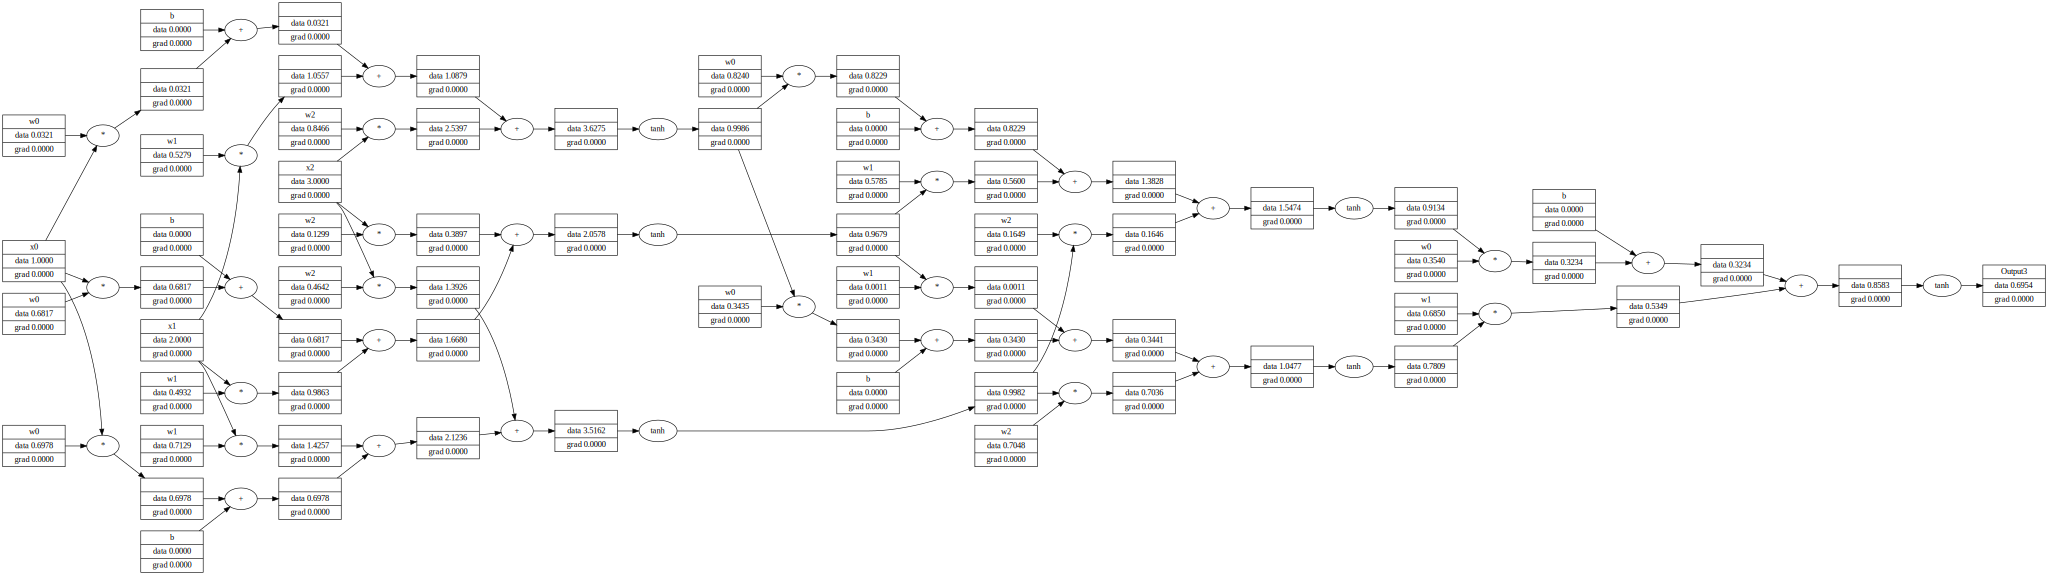

In [26]:
get_expression_graph(output3)